# Intro to Neural Networks

In [12]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [16]:
def preprocess_features(california_housing_dataframe):
    """
    Prepare input features from CA housing data set
    
    Args:
        california_housing_dataframe: A 'DataFrame' with CA housing data set
    Returns:
        A 'DataFrame' containing features to be used for the model, including synthetic features
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    preprocesed_features = selected_features.copy()
    preprocesed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return preprocesed_features

In [17]:
def preprocess_targets(california_housing_dataframe):
    """
    Prepare target features from CA housing data set

    Args:
        california_housing_dataframe: A 'DataFrame' with CA housing data set
    Returns:
        A 'DataFrame' containing the target feature
    """
    df = pd.DataFrame()
    df["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return df

### split data into training / validation

In [18]:
training_examples = preprocess_features(california_housing_dataframe).head(12000)
training_targets = preprocess_targets(california_housing_dataframe).head(12000)

validation_examples = preprocess_features(california_housing_dataframe).tail(5000)
validation_targets = preprocess_targets(california_housing_dataframe).tail(5000)

In [19]:
print("Training examples summary")
display.display(training_examples.describe())
print("Validation examples summary")
display.display(validation_examples.describe())

print("Training targets summary")
display.display(training_targets.describe())
print("Validation targets summary")
display.display(validation_targets.describe())

Training examples summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2643.5,541.0,1436.1,503.0,3.9,2.0
std,2.1,2.0,12.6,2171.7,423.4,1125.7,385.1,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1457.8,299.0,793.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2137.0,438.0,1175.0,412.5,3.5,1.9
75%,37.7,-118.0,37.0,3162.0,653.0,1733.0,610.2,4.7,2.3
max,42.0,-114.5,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2643.9,535.7,1413.9,496.9,3.9,2.0
std,2.2,2.0,12.6,2199.8,417.0,1199.4,383.1,2.0,1.2
min,32.5,-124.3,1.0,18.0,3.0,8.0,5.0,0.5,0.2
25%,33.9,-121.8,18.0,1471.8,293.0,782.0,277.0,2.6,1.5
50%,34.2,-118.5,29.0,2105.5,425.0,1146.0,401.0,3.6,2.0
75%,37.7,-118.0,37.0,3125.2,637.2,1696.2,591.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,34.2


Training targets summary


,median_house_value
count,12000.0
mean,206.3
std,114.8
min,15.0
25%,120.0
50%,179.8
75%,263.3
max,500.0


Validation targets summary


,median_house_value
count,5000.0
mean,209.6
std,118.7
min,17.5
25%,118.8
50%,181.4
75%,269.8
max,500.0


## Build Neural Network

In [20]:
def construct_feature_columns(input_features):
    """
    Construct the TensorFlow feature columns
    
    Args:
        input_features: Names of the numerical input features to use
    Returns:
        A set of feature columns
    """
    return set([tf.feature_column.numeric_column(feature) for feature in input_features])

In [21]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Trains a neural network regression model
    
    Args:
        features: 'DataFrame' of features
        targets: 'DataFrame' of targets
        batch_size: Number of batches to pass to model
        shuffle: True or False, whether to shuffle the data
        num_epochs: Number of epochs to repeat over the data, value of 'None' goes indefinitely
    Returns:
        Tuple of (features,targets) for next data batch
    """
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds.shuffle(10000)
    
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels

In [32]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """
    Trains a neural network regression model.
    
    Print training progress information, and plot training/validation loss over time
    
    Args:
        learning_rate: A 'float', the learning rate
        steps: A non-zero 'int', the total number of training steps.  A training step consists
            of a forward and backward using a single batch
        batch_size: A non-zero 'int', the batch size
        hidden_units: A 'list' of int values, specifying number of neurons in each layer
        training_examples: A 'DataFrame' containing one or more columns from the CA housing data set
        training_targets: A 'DataFrame' containing exactly one column from CA housing data set
        validation_examples: A 'DataFrame' containing one or more columns from the CA housing data set
        validation_targets: A 'DataFrame' containing exactly one column from the CA housing data set
    Returns:
        A 'DNNRegressor' object trained on training data
    """
    periods = 10
    steps_per_period = steps / periods
    
    
    # create DNNRegressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=my_optimizer)
    
    # create input features
    target_col = "median_house_value"
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets[target_col], batch_size=batch_size)
    predictions_training_input_fn = lambda: my_input_fn(training_examples, training_targets[target_col], 
                                                        shuffle=False, num_epochs=1)
    predictions_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets[target_col], 
                                                         shuffle=False, num_epochs=1)
    
    # train the model
    print("Training model...")
    print("RMSE (training)")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        # train from prior state
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # compute predictions
        training_predictions = dnn_regressor.predict(input_fn=predictions_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])
        
        validation_predictions = dnn_regressor.predict(input_fn=predictions_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
        
        # compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_targets, training_predictions))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_targets, validation_predictions))
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished")
    print("Final RMSE(training): %0.2f" % training_root_mean_squared_error)
    print("Final RMSE(validation): %0.2f" % validation_root_mean_squared_error)
    
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("RMSE vs Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return dnn_regressor

## Task 1: Train a NN Model

Training model...
RMSE (training)
  period 00 : 166.05
  period 01 : 165.91
  period 02 : 163.45
  period 03 : 160.12
  period 04 : 153.01
  period 05 : 164.07
  period 06 : 143.93
  period 07 : 141.01
  period 08 : 139.08
  period 09 : 137.60
Model training finished


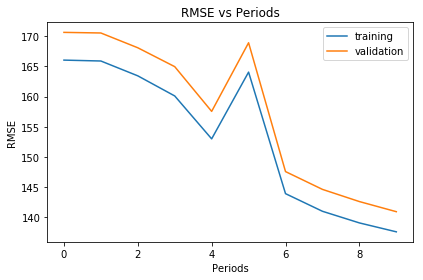

In [29]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10,2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### try to drop below 110 rmse

Training model...
RMSE (training)
  period 00 : 149.15
  period 01 : 128.07
  period 02 : 113.66
  period 03 : 108.86
  period 04 : 107.24
  period 05 : 106.09
  period 06 : 105.37
  period 07 : 104.89
  period 08 : 104.53
  period 09 : 104.21
Model training finished
Final RMSE(training): 104.21
Final RMSE(validation): 108.20


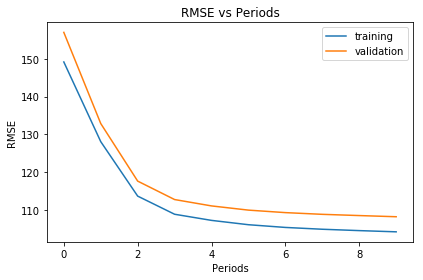

In [34]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=500,
    hidden_units=[10,10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 2: Evaluate on Test Data

In [37]:
california_housing_test_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

In [41]:
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predictions_test_input_fn = lambda: my_input_fn(test_examples, test_targets["median_house_value"], 
                                                        shuffle=False, num_epochs=1)

preds = dnn_regressor.predict(predictions_test_input_fn)
preds = np.array([item["predictions"][0] for item in preds])

print("RMSE (testing): %0.2f" % math.sqrt(metrics.mean_squared_error(preds, test_targets)))

RMSE (testing): 102.59
